In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sksurv.nonparametric import kaplan_meier_estimator
from tqdm.notebook import tqdm, trange
from copy import deepcopy
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines import CoxTimeVaryingFitter

# own imports
from src.utils import create_nfl_field
from src.utils import load_data
from src.utils import life_expectancy

np.set_printoptions(precision=4)
pd.set_option("display.precision", 4)

In [2]:
games, plays, players, scouting, plays_with_collapse, off_cols, def_cols = (
        load_data()
    )
players_with_collapse = pd.merge(
        scouting[scouting.pff_role.isin(["Pass", "Pass Rush", "Pass Block"])][
            ["gameId", "playId", "nflId", "pff_role"]
        ],
        plays_with_collapse,
        how="right",
        on=["gameId", "playId"],
    )


/home/mace/Documents/Python/NFLPocketSurvival/src/utils.py:316: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(poly_frame)
/home/mace/Documents/Python/NFLPocketSurvival/src/utils.py:323: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(min_frame)
/home/mace/Documents/Python/NFLPocketSurvival/src/utils.py:330: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated

timed_pocketsizes.shape=(8557, 10)


In [3]:

off_team_cols = [
        "possessionTeam_ATL",
        "possessionTeam_BAL",
        "possessionTeam_BUF",
        "possessionTeam_CAR",
        "possessionTeam_CHI",
        "possessionTeam_CIN",
        "possessionTeam_CLE",
        "possessionTeam_DAL",
        "possessionTeam_DEN",
        "possessionTeam_DET",
        "possessionTeam_GB",
        "possessionTeam_HOU",
        "possessionTeam_IND",
        "possessionTeam_JAX",
        "possessionTeam_KC",
        "possessionTeam_LA",
        "possessionTeam_LAC",
        "possessionTeam_LV",
        "possessionTeam_MIA",
        "possessionTeam_MIN",
        "possessionTeam_NE",
        "possessionTeam_NO",
        "possessionTeam_NYG",
        "possessionTeam_NYJ",
        "possessionTeam_PHI",
        "possessionTeam_PIT",
        "possessionTeam_SEA",
        "possessionTeam_SF",
        "possessionTeam_TB",
        "possessionTeam_TEN",
        "possessionTeam_WAS",
    ]

def_team_cols = [
        "defensiveTeam_ATL",
        "defensiveTeam_BAL",
        "defensiveTeam_BUF",
        "defensiveTeam_CAR",
        "defensiveTeam_CHI",
        "defensiveTeam_CIN",
        "defensiveTeam_CLE",
        "defensiveTeam_DAL",
        "defensiveTeam_DEN",
        "defensiveTeam_DET",
        "defensiveTeam_GB",
        "defensiveTeam_HOU",
        "defensiveTeam_IND",
        "defensiveTeam_JAX",
        "defensiveTeam_KC",
        "defensiveTeam_LA",
        "defensiveTeam_LAC",
        "defensiveTeam_LV",
        "defensiveTeam_MIA",
        "defensiveTeam_MIN",
        "defensiveTeam_NE",
        "defensiveTeam_NO",
        "defensiveTeam_NYG",
        "defensiveTeam_NYJ",
        "defensiveTeam_PHI",
        "defensiveTeam_PIT",
        "defensiveTeam_SEA",
        "defensiveTeam_SF",
        "defensiveTeam_TB",
        "defensiveTeam_TEN",
        "defensiveTeam_WAS",
    ]

    ## subset of feature columns
base_feat = [
        "yardsToGo",
        "defendersInBox",
        "Cover-0",
        "Cover-1",
        "Cover-2",
        "Cover-6",
        "misc_def",
        "Quarters",  # cover 4
        "2-Man",  # "cover 5"ish
        "pff_playAction",
        "down2",
        "down3",
        "shotgun",
    ]
opt_feat = ["mean_polydists"] + [f"poly_tau_{i}" for i in range(5, 41, 5)]


In [4]:
norm_cols = list(
        set(base_feat + opt_feat).intersection(
            ["mean_polydists", "defendersInBox", "yardsToGo"]
            + [f"poly_tau_{i}" for i in range(5, 41, 5)]
        )
    )

In [5]:
plays_with_collapse["misc_def"] = plays_with_collapse.pff_passCoverage.isin(
        ["Red Zone", "Bracket", "Prevent", "Miscellaneous"]
    )

In [6]:
X = pd.get_dummies(
        plays_with_collapse[base_feat + opt_feat + ["defensiveTeam", "possessionTeam"]],
        columns=["defensiveTeam", "possessionTeam"],
    )
X[["defensiveTeam", "possessionTeam"]] = plays_with_collapse[
        ["defensiveTeam", "possessionTeam"]
    ]

In [7]:
X.head()

,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,...,possessionTeam_NYJ,possessionTeam_PHI,possessionTeam_PIT,possessionTeam_SEA,possessionTeam_SF,possessionTeam_TB,possessionTeam_TEN,possessionTeam_WAS,defensiveTeam,possessionTeam
0,2,6.0,False,True,False,False,False,False,False,0,...,False,False,False,False,False,True,False,False,DAL,TB
1,10,6.0,False,False,False,False,False,False,False,0,...,False,False,False,False,False,False,False,False,TB,DAL
2,6,6.0,False,False,False,False,False,False,False,0,...,False,False,False,False,False,False,False,False,TB,DAL
3,10,6.0,False,False,False,False,False,False,False,1,...,False,False,False,False,False,False,False,False,TB,DAL
4,15,7.0,False,False,False,False,False,False,False,0,...,False,False,False,False,False,False,False,False,TB,DAL


In [8]:
# X[norm_cols] = (X[norm_cols] - X[norm_cols].mean()) / X[norm_cols].std()
Y = plays_with_collapse[["survived", "surv_frame", "pass_frame"]]

In [9]:
X["time"] = Y[["surv_frame", "pass_frame"]].min(axis=1)
X["collapse_event"] = (~Y["survived"]) & (Y.surv_frame.lt(Y.pass_frame))
X["pass_event"] = Y.surv_frame.gt(Y.pass_frame)

In [10]:
## at this point, we have a _short_ dataset X,Y
## Now we have to figure out a way of how to build the "correct" full Dataset. 

In [11]:
X.columns

Index(['yardsToGo', 'defendersInBox', 'Cover-0', 'Cover-1', 'Cover-2',
       'Cover-6', 'misc_def', 'Quarters', '2-Man', 'pff_playAction', 'down2',
       'down3', 'shotgun', 'mean_polydists', 'poly_tau_5', 'poly_tau_10',
       'poly_tau_15', 'poly_tau_20', 'poly_tau_25', 'poly_tau_30',
       'poly_tau_35', 'poly_tau_40', 'defensiveTeam_ARI', 'defensiveTeam_ATL',
       'defensiveTeam_BAL', 'defensiveTeam_BUF', 'defensiveTeam_CAR',
       'defensiveTeam_CHI', 'defensiveTeam_CIN', 'defensiveTeam_CLE',
       'defensiveTeam_DAL', 'defensiveTeam_DEN', 'defensiveTeam_DET',
       'defensiveTeam_GB', 'defensiveTeam_HOU', 'defensiveTeam_IND',
       'defensiveTeam_JAX', 'defensiveTeam_KC', 'defensiveTeam_LA',
       'defensiveTeam_LAC', 'defensiveTeam_LV', 'defensiveTeam_MIA',
       'defensiveTeam_MIN', 'defensiveTeam_NE', 'defensiveTeam_NO',
       'defensiveTeam_NYG', 'defensiveTeam_NYJ', 'defensiveTeam_PHI',
       'defensiveTeam_PIT', 'defensiveTeam_SEA', 'defensiveTeam_SF',
       '

In [12]:
X.loc[X.collapse_event == X.pass_event, ['time', 'collapse_event', 'pass_event']]

,time,collapse_event,pass_event
10,24,False,False
28,26,False,False
50,21,False,False
59,34,False,False
99,18,False,False
...,...,...,...
7968,34,False,False
7973,23,False,False
8097,15,False,False
8170,32,False,False


In [130]:
datapoints = []
for idx in trange(len(X)): 
    d = X.iloc[idx].to_dict()
    for ti in range(5, min(d["time"]+5, 41), 5): 
        start = ti-5
        if (ti < 40) and (ti < d["time"]): 
            stop = ti 
        else: 
            stop = d["time"]
        pocket_size = d[f"poly_tau_{ti}"]
        pass_event = d["pass_event"] & ( d["time"] <= stop) 
        collapse_event = d["collapse_event"] & ( d["time"] <= stop) 
        
        dp = deepcopy(d) 
        dp["id"] = idx
        dp["start"] = start
        dp["stop"] = stop
        dp["pocket_size"] = pocket_size
        dp["pass_event"] = pass_event
        dp["collapse_event"] = collapse_event
        datapoints.append(dp)
    

  0%|          | 0/8204 [00:00<?, ?it/s]

In [131]:
tv_cols = ["id", "start", "stop", "pocket_size"]

In [132]:
tvx = pd.DataFrame(datapoints)

In [16]:
X_train, X_test = train_test_split(tvx.id.unique(), test_size=0.2)

In [133]:
tvx.loc[tvx.id.isin(X_train), tv_cols+base_feat+["pass_event", "collapse_event"]].head(10)

,id,start,stop,pocket_size,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,down2,down3,shotgun,pass_event,collapse_event
0,0,0,5,4.8251,2,6.0,False,True,False,False,False,False,False,0,False,True,True,False,False
1,0,5,10,4.7084,2,6.0,False,True,False,False,False,False,False,0,False,True,True,False,False
2,0,10,15,3.8422,2,6.0,False,True,False,False,False,False,False,0,False,True,True,False,False
3,0,15,20,1.5468,2,6.0,False,True,False,False,False,False,False,0,False,True,True,False,False
4,0,20,25,0.5810,2,6.0,False,True,False,False,False,False,False,0,False,True,True,False,False
5,0,25,29,0.0000,2,6.0,False,True,False,False,False,False,False,0,False,True,True,False,True
6,1,0,5,4.4757,10,6.0,False,False,False,False,False,False,False,0,False,False,False,False,False
7,1,5,10,4.0413,10,6.0,False,False,False,False,False,False,False,0,False,False,False,False,False
8,1,10,15,3.6226,10,6.0,False,False,False,False,False,False,False,0,False,False,False,False,False
9,1,15,20,1.6771,10,6.0,False,False,False,False,False,False,False,0,False,False,False,False,False


In [18]:
pass_ctv = CoxTimeVaryingFitter(penalizer=0.1)
pass_ctv.fit(tvx.loc[tvx.id.isin(X_train), tv_cols+base_feat+["pass_event"]], id_col="id", event_col="pass_event", start_col="start", stop_col="stop", show_progress=True)
pass_ctv.print_summary()

Iteration 1: norm_delta = 1.78e-01, step_size = 0.9500, log_lik = -22408.45594, newton_decrement = 1.10e+02, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.27e-02, step_size = 0.9500, log_lik = -22297.74113, newton_decrement = 5.88e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 6.72e-04, step_size = 0.9500, log_lik = -22297.15385, newton_decrement = 1.65e-03, seconds_since_start = 0.1
Iteration 4: norm_delta = 3.55e-05, step_size = 1.0000, log_lik = -22297.15221, newton_decrement = 4.16e-06, seconds_since_start = 0.1
Iteration 5: norm_delta = 3.10e-10, step_size = 1.0000, log_lik = -22297.15220, newton_decrement = 3.69e-16, seconds_since_start = 0.1
Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 34377 periods, 6563 subjects, 2859 events>
         event col = 'pass_event'
         penalizer = 0.1
number of subjects = 6563
 number of periods = 34377
  number of events = 2859
partial log-likelihood = -22297.15
  time fit was run = 2026-02-19 09:39:10 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
pocket_size    -0.07      0.93      0.01           -0.08           -0.05                0.92                0.95
yardsToGo      -0.01      0.99      0.00           -0.01           -0.00                0.99                1.00
defendersInBox  0.00      1.00      0.01           -0.02            0.03                0.98                1.03
Cover-0         0.20      1.23      0.09            0.03            0.38                1.03                1.46
Cover-1         0.01      1.01      0.03           -0.05            0.07                0.95                1.08
Cover-2        -0.02      0.98      0.04           -0.09            0.06                0.92                1.06
Cover-6        -0.02      0.98      0.04           -0.10            0.07                0.91                1.07
misc_def       -0.15      0.86      0.06           -0.27           -0.04                0.77                0.96
Quarters       -0.01      0.99      0.04           -0.09            0.07                0.92                1.07
2-Man          -0.13      0.88      0.08           -0.29            0.03                0.75                1.03
pff_playAction -0.31      0.74      0.03           -0.37           -0.25                0.69                0.78
down2           0.06      1.06      0.03            0.01            0.11                1.01                1.12
down3          -0.10      0.91      0.03           -0.15           -0.04                0.86                0.96
shotgun        -0.00      1.00      0.03           -0.06            0.05                0.95                1.05

                cmp to      z      p  -log2(p)
covariate                                     
pocket_size       0.00  -8.26 <0.005     52.62
yardsToGo         0.00  -2.48   0.01      6.25
defendersInBox    0.00   0.18   0.85      0.23
Cover-0           0.00   2.31   0.02      5.60
Cover-1           0.00   0.46   0.65      0.63
Cover-2           0.00  -0.42   0.67      0.57
Cover-6           0.00  -0.39   0.69      0.53
misc_def          0.00  -2.60   0.01      6.76
Quarters          0.00  -0.28   0.78      0.37
2-Man             0.00  -1.57   0.12      3.10
pff_playAction    0.00 -10.07 <0.005     76.84
down2             0.00   2.19   0.03      5.13
down3             0.00  -3.25 <0.005      9.78
shotgun           0.00  -0.12   0.90      0.15
---
Partial AIC = 44622.30
log-likelihood ratio test = 222.61 on 14 df
-log2(p) of ll-ratio test = 129.20

<Axes: xlabel='log(HR) (95% CI)'>

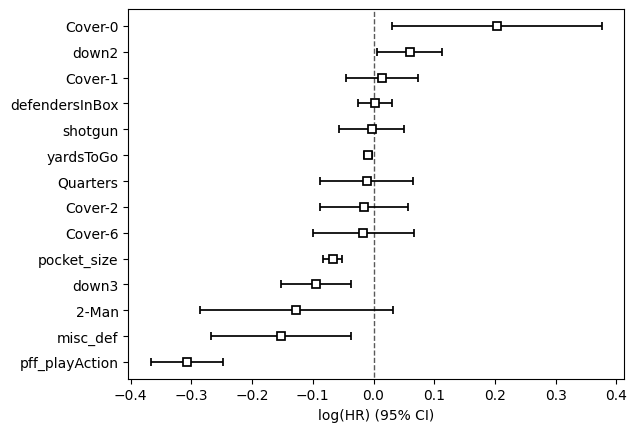

In [19]:
pass_ctv.plot()

In [20]:
X_test

array([6911, 2442, 7640, ..., 8094, 6308, 3875], shape=(1641,))

In [21]:
tvx.loc[tvx.id.isin([2486])]

,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,...,possessionTeam_WAS,defensiveTeam,possessionTeam,time,collapse_event,pass_event,id,start,stop,pocket_size
12952,10,5.0,False,False,True,False,False,False,False,0,...,False,ARI,JAX,24,False,False,2486,0,5,4.7007
12953,10,5.0,False,False,True,False,False,False,False,0,...,False,ARI,JAX,24,False,False,2486,5,10,4.0947
12954,10,5.0,False,False,True,False,False,False,False,0,...,False,ARI,JAX,24,False,False,2486,10,15,3.9046
12955,10,5.0,False,False,True,False,False,False,False,0,...,False,ARI,JAX,24,False,False,2486,15,20,3.6045
12956,10,5.0,False,False,True,False,False,False,False,0,...,False,ARI,JAX,24,True,False,2486,20,24,0.0000


In [22]:
pred = pass_ctv.predict_partial_hazard(tvx.loc[tvx.id.isin([2486]), tv_cols+base_feat+["pass_event"]]).values

In [23]:
pred

array([1.0134, 1.0555, 1.0691, 1.0909, 1.3901])

In [24]:
plot_pred = np.hstack([[pri]*5 for pri in pred])
np.multiply(plot_pred, pass_ctv.baseline_cumulative_hazard_.values[:len(plot_pred), 0])

array([1.6201e-04, 6.4850e-04, 1.1190e-03, 2.6924e-03, 5.5419e-03,
       1.1622e-02, 3.0783e-02, 5.9088e-02, 9.6503e-02, 1.3856e-01,
       1.8647e-01, 2.4193e-01, 3.0296e-01, 3.7327e-01, 4.5547e-01,
       5.4272e-01, 6.3237e-01, 7.1744e-01, 8.0849e-01, 8.8975e-01,
       1.2600e+00, 1.3949e+00, 1.4898e+00, 1.5965e+00, 1.6827e+00])

In [25]:
plot_pred

array([1.0134, 1.0134, 1.0134, 1.0134, 1.0134, 1.0555, 1.0555, 1.0555,
       1.0555, 1.0555, 1.0691, 1.0691, 1.0691, 1.0691, 1.0691, 1.0909,
       1.0909, 1.0909, 1.0909, 1.0909, 1.3901, 1.3901, 1.3901, 1.3901,
       1.3901])

In [26]:
pass_ctv.baseline_cumulative_hazard_.values[:len(plot_pred), 0]

array([1.5987e-04, 6.3994e-04, 1.1042e-03, 2.6568e-03, 5.4687e-03,
       1.1011e-02, 2.9164e-02, 5.5979e-02, 9.1426e-02, 1.3128e-01,
       1.7442e-01, 2.2630e-01, 2.8337e-01, 3.4914e-01, 4.2603e-01,
       4.9750e-01, 5.7968e-01, 6.5767e-01, 7.4112e-01, 8.1562e-01,
       9.0640e-01, 1.0035e+00, 1.0717e+00, 1.1485e+00, 1.2105e+00])

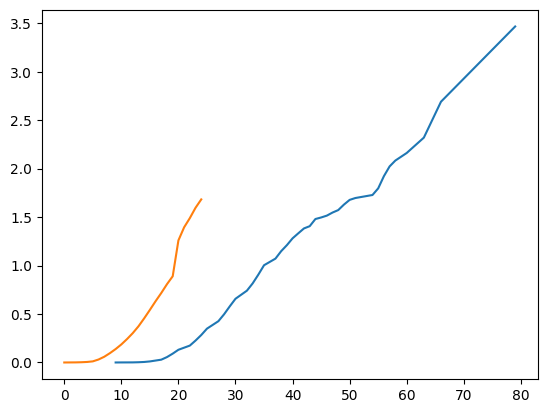

In [27]:
plt.plot(pass_ctv.baseline_cumulative_hazard_, label='baseline_cumulative_hazard')
plt.plot(np.multiply(plot_pred, pass_ctv.baseline_cumulative_hazard_.values[:len(plot_pred), 0]), label="basline*partial")

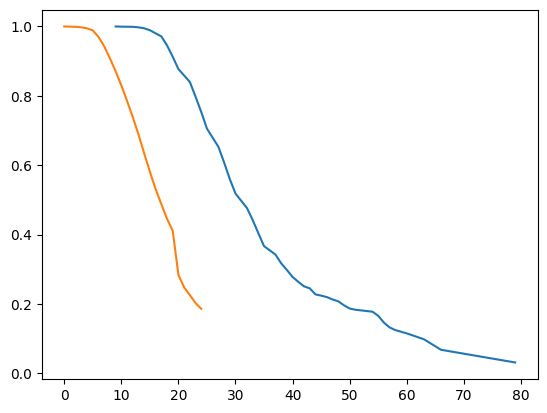

In [28]:
plt.plot(np.exp(-pass_ctv.baseline_cumulative_hazard_), label='baseline_cumulative_survival')
plt.plot(np.exp(-1*np.multiply(plot_pred, pass_ctv.baseline_cumulative_hazard_.values[:len(plot_pred), 0])), label="basline*partial")

In [29]:
collapse_ctv = CoxTimeVaryingFitter(penalizer=0.1)
collapse_ctv.fit(tvx.loc[tvx.id.isin(X_train), tv_cols+base_feat+["collapse_event"]], id_col="id", event_col="collapse_event", start_col="start", stop_col="stop", show_progress=True)
collapse_ctv.print_summary()

Iteration 1: norm_delta = 5.26e-01, step_size = 0.9500, log_lik = -17647.32426, newton_decrement = 8.02e+02, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.01e-02, step_size = 0.9500, log_lik = -16830.43894, newton_decrement = 7.01e+00, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.80e-03, step_size = 0.9500, log_lik = -16823.41821, newton_decrement = 2.17e-02, seconds_since_start = 0.1
Iteration 4: norm_delta = 1.48e-04, step_size = 1.0000, log_lik = -16823.39658, newton_decrement = 5.49e-05, seconds_since_start = 0.1
Iteration 5: norm_delta = 2.44e-09, step_size = 1.0000, log_lik = -16823.39652, newton_decrement = 1.60e-14, seconds_since_start = 0.1
Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 34377 periods, 6563 subjects, 2261 events>
         event col = 'collapse_event'
         penalizer = 0.1
number of subjects = 6563
 number of periods = 34377
  number of events = 2261
partial log-likelihood = -16823.40
  time fit was run = 2026-02-19 09:45:22 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
pocket_size    -0.35      0.71      0.01           -0.36           -0.33                0.69                0.72
yardsToGo      -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
defendersInBox  0.03      1.03      0.01           -0.00            0.06                1.00                1.06
Cover-0         0.28      1.32      0.09            0.11            0.45                1.12                1.57
Cover-1         0.01      1.01      0.03           -0.05            0.07                0.95                1.08
Cover-2        -0.08      0.92      0.04           -0.15           -0.00                0.86                1.00
Cover-6        -0.04      0.96      0.05           -0.13            0.05                0.88                1.05
misc_def        0.01      1.01      0.06           -0.11            0.13                0.90                1.14
Quarters       -0.00      1.00      0.04           -0.08            0.08                0.92                1.08
2-Man          -0.11      0.90      0.09           -0.28            0.06                0.76                1.06
pff_playAction  0.10      1.10      0.03            0.04            0.16                1.04                1.17
down2           0.01      1.01      0.03           -0.04            0.07                0.96                1.07
down3           0.05      1.05      0.03           -0.01            0.11                0.99                1.11
shotgun        -0.05      0.95      0.03           -0.10            0.01                0.90                1.01

                cmp to      z      p  -log2(p)
covariate                                     
pocket_size       0.00 -39.47 <0.005       inf
yardsToGo         0.00  -0.92   0.36      1.49
defendersInBox    0.00   1.84   0.07      3.93
Cover-0           0.00   3.20 <0.005      9.51
Cover-1           0.00   0.39   0.70      0.51
Cover-2           0.00  -1.99   0.05      4.44
Cover-6           0.00  -0.87   0.39      1.38
misc_def          0.00   0.20   0.84      0.25
Quarters          0.00  -0.10   0.92      0.12
2-Man             0.00  -1.25   0.21      2.24
pff_playAction    0.00   3.15 <0.005      9.26
down2             0.00   0.45   0.65      0.62
down3             0.00   1.54   0.12      3.02
shotgun           0.00  -1.71   0.09      3.51
---
Partial AIC = 33674.79
log-likelihood ratio test = 1647.86 on 14 df
-log2(p) of ll-ratio test = inf

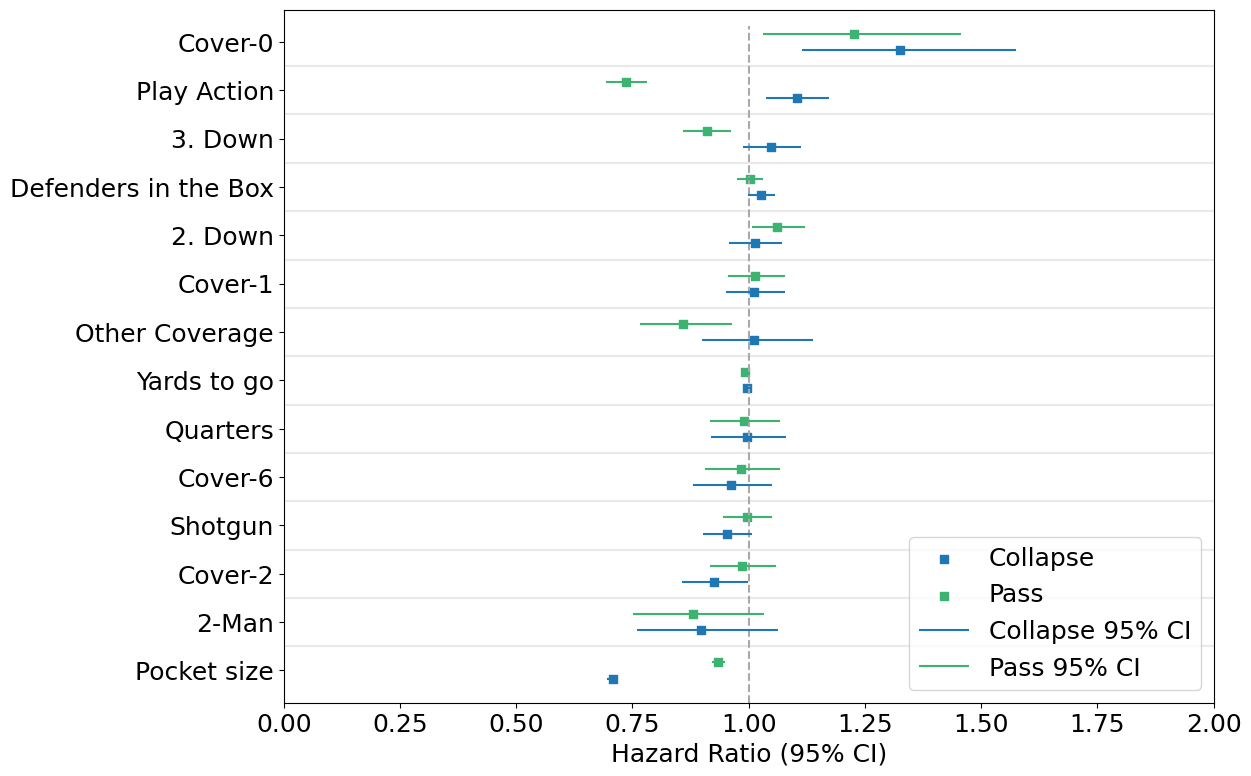

In [50]:
with plt.style.context({"font.size":18}):
    fig, ax = plt.subplots(figsize=(12,9))
    ax.vlines([1.0], ymin=-1, ymax=41, linestyles="--", color="darkgray")
    plt.xlabel("Hazard Ratio (95% CI)")

    yticklabel_dict = {
        "Cover-0":"Cover-0", 
        "Cover-1":"Cover-1", 
        "Cover-2":"Cover-2", 
        "Cover-6":"Cover-6", 
        "Quarters":"Quarters",
        "2-Man":"2-Man",
        "shotgun":"Shotgun", 
        "down3":"3. Down", 
        "down2":"2. Down", 
        "yardsToGo":"Yards to go", 
        "misc_def": "Other Coverage", 
        "pocket_size": "Pocket size", 
        "defendersInBox": "Defenders in the Box", 
        "pff_playAction":"Play Action"
    }

    hr_plot_df = pd.DataFrame({
        "collapse_hr":collapse_ctv.hazard_ratios_,
        "pass_hr":pass_ctv.hazard_ratios_,
        "collapse_lb":np.exp(collapse_ctv.confidence_intervals_["95% lower-bound"]),
        "collapse_ub":np.exp(collapse_ctv.confidence_intervals_["95% upper-bound"]),
        "pass_lb":np.exp(pass_ctv.confidence_intervals_["95% lower-bound"]),
        "pass_ub":np.exp(pass_ctv.confidence_intervals_["95% upper-bound"]),
    }).reset_index().sort_values("collapse_hr")

    y_loc = np.arange(1,43,3)
    hr_plot_df["covariate"] = hr_plot_df["covariate"].map(yticklabel_dict)

    ax.scatter(hr_plot_df["collapse_hr"].values, y_loc-0.5, marker="s", label="Collapse")
    ax.scatter(hr_plot_df["pass_hr"].values, y_loc+0.5, marker="s", color="mediumseagreen", label="Pass")

    ax.hlines(y_loc-0.5, hr_plot_df["collapse_lb"], hr_plot_df["collapse_ub"], label="Collapse 95% CI")
    ax.hlines(y_loc+0.5, hr_plot_df["pass_lb"], hr_plot_df["pass_ub"], label="Pass 95% CI", color="mediumseagreen")
    
    ax.hlines(y_loc[:-1]+1.5, xmin=0.0, xmax=4, color="darkgray", alpha=.25)

    ax.set_yticks(y_loc, hr_plot_df["covariate"].values)
    plt.xlim(0,2)
    plt.ylim(-1,42)
    plt.legend(loc="lower right")
    plt.savefig("time_vary_hr.png", dpi=600)
    plt.show()

## so we now have two models, each of which allows to estimate the hazard conditional on the pocket size
### next step is then to use the hazards to estimate the cumulative incidence conditional on the pocket size
### do we also want to predict / estimate the pocket size pre snap? 

In [56]:
tvx.loc[tvx.id.isin([X_test])]

,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,...,possessionTeam_WAS,defensiveTeam,possessionTeam,time,collapse_event,pass_event,id,start,stop,pocket_size


In [59]:
collapse_ctv.predict_partial_hazard(tvx.loc[tvx.id.isin(X_test), tv_cols+base_feat+["collapse_event"]])

0       0.5383
1       0.4736
2       0.8973
3       2.5287
4       2.4566
         ...  
8663    1.7258
8664    1.6777
8665    0.8996
8666    1.3199
8667    1.9764
Length: 8668, dtype: float64

In [175]:
hdf = pd.concat([
    pd.Series(np.arange(100), name="t"), 
    collapse_ctv.baseline_survival_.rename(columns={"baseline survival":"baseline_collapse_survival"}), 
    collapse_ctv.baseline_cumulative_hazard_.rename(columns={"baseline hazard":"baseline_collapse_cum_hazard"}),
    pass_ctv.baseline_survival_.rename(columns={"baseline survival":"baseline_pass_survival"}), 
    pass_ctv.baseline_cumulative_hazard_.rename(columns={"baseline hazard":"baseline_pass_cum_hazard"})
    ], axis=1)
hdf['baseline_collapse_survival'] = hdf['baseline_collapse_survival'].ffill().fillna(1.0)
hdf['baseline_collapse_cum_hazard'] = hdf['baseline_collapse_cum_hazard'].ffill().fillna(0.0)

hdf['baseline_pass_survival'] = hdf['baseline_pass_survival'].ffill().fillna(1.0)
hdf['baseline_pass_cum_hazard'] = hdf['baseline_pass_cum_hazard'].ffill().fillna(0.0)

hdf['baseline_collapse_hazard'] = hdf['baseline_collapse_cum_hazard'].diff().fillna(0.0)
hdf['baseline_pass_hazard'] = hdf['baseline_pass_cum_hazard'].diff().fillna(0.0)
hdf.head(15)


,t,baseline_collapse_survival,baseline_collapse_cum_hazard,baseline_pass_survival,baseline_pass_cum_hazard,baseline_collapse_hazard,baseline_pass_hazard
0,0,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
1,1,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
2,2,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
3,3,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
4,4,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
5,5,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
6,6,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
7,7,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
8,8,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
9,9,0.9992,0.0008,0.9998,0.0002,0.0008,0.0002


<Axes: >

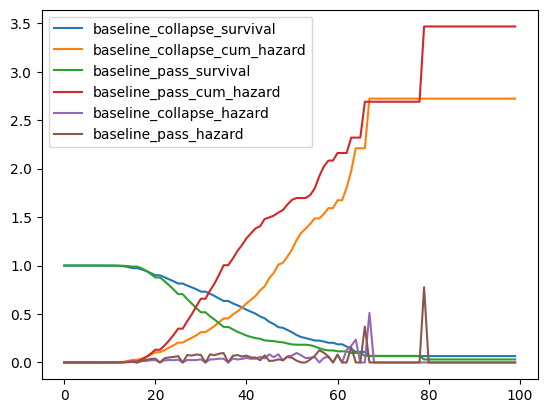

In [176]:
hdf.drop(columns=["t"]).plot()

In [238]:
pass_calib = [[] for _ in range(100)]
total_passes = 0

collapse_calib = [[] for _ in range(100)]
total_collapses = 0

for test_id in tqdm(X_train): 
    input_df = tvx.loc[tvx.id==test_id, tv_cols+base_feat+["collapse_event", "pass_event"]]
    
    pred_partial_hazard_collapse = collapse_ctv.predict_partial_hazard(input_df)
    pred_partial_hazard_collapse.index = input_df.stop

    pred_partial_hazard_pass = collapse_ctv.predict_partial_hazard(input_df)
    pred_partial_hazard_pass.index = input_df.stop

    df = pd.concat([
        hdf["baseline_collapse_hazard"], 
        pred_partial_hazard_collapse.rename("partial_collapse_hazard"),
        hdf["baseline_pass_hazard"], 
        pred_partial_hazard_pass.rename("partial_pass_hazard")
        ],axis=1)

    df["partial_collapse_hazard"] = df["partial_collapse_hazard"].bfill()
    df["collapse_hazard"] = df["partial_collapse_hazard"]*df["baseline_collapse_hazard"]
    df["cum_collapse_hazard"] = df["collapse_hazard"].cumsum()

    df["partial_pass_hazard"] = df["partial_pass_hazard"].bfill()
    df["pass_hazard"] = df["partial_pass_hazard"]*df["baseline_pass_hazard"]
    df["cum_pass_hazard"] = df["pass_hazard"].cumsum()
    
    stop_time = input_df["stop"].max()
    for vh in df.collapse_hazard.head(stop_time).values: 
        collapse_calib[min(int(vh*100), 99)].append(0)
    for vh in df.pass_hazard.head(stop_time).values: 
        pass_calib[min(int(vh*100), 99)].append(0)
    
    chzd = df[["collapse_hazard", "cum_collapse_hazard"]].iloc[stop_time].to_dict()
    phzd = df[["pass_hazard", "cum_pass_hazard"]].iloc[stop_time].to_dict()

    if input_df["collapse_event"].max(): 
        collapse_calib[min(int(chzd["collapse_hazard"]*100), 99)].append(1) 
        total_collapses += 1      

    if input_df["pass_event"].max(): 
        pass_calib[min(int(phzd["pass_hazard"]*100), 99)].append(1)        
        total_passes += 1
    
    # print(stop_time, collapse_happened, pass_happened)
    # print("collapse hazard@stop: ", df[["collapse_hazard", "cum_collapse_hazard"]].iloc[stop_time].to_dict())
    # does this mean, 2.93 % of times this should have collapsed here / 0.0666 percent should have died until this step? 




    # pred_partial_hazard_pass = pass_ctv.predict_partial_hazard(tvx.loc[tvx.id==test_id, tv_cols+base_feat+["pass_event"]])
    # partial hazard is grouped in 5s. 

  0%|          | 0/6563 [00:00<?, ?it/s]

In [239]:
input_df


,id,start,stop,pocket_size,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,down2,down3,shotgun,collapse_event,pass_event
41438,7631,0,5,4.7828,2,7.0,True,False,False,False,False,False,False,0,False,True,True,False,False
41439,7631,5,10,4.9437,2,7.0,True,False,False,False,False,False,False,0,False,True,True,False,False
41440,7631,10,15,5.1421,2,7.0,True,False,False,False,False,False,False,0,False,True,True,False,False
41441,7631,15,20,4.9504,2,7.0,True,False,False,False,False,False,False,0,False,True,True,False,False
41442,7631,20,25,4.5995,2,7.0,True,False,False,False,False,False,False,0,False,True,True,False,False
41443,7631,25,30,1.4585,2,7.0,True,False,False,False,False,False,False,0,False,True,True,False,False
41444,7631,30,34,0.0000,2,7.0,True,False,False,False,False,False,False,0,False,True,True,False,False


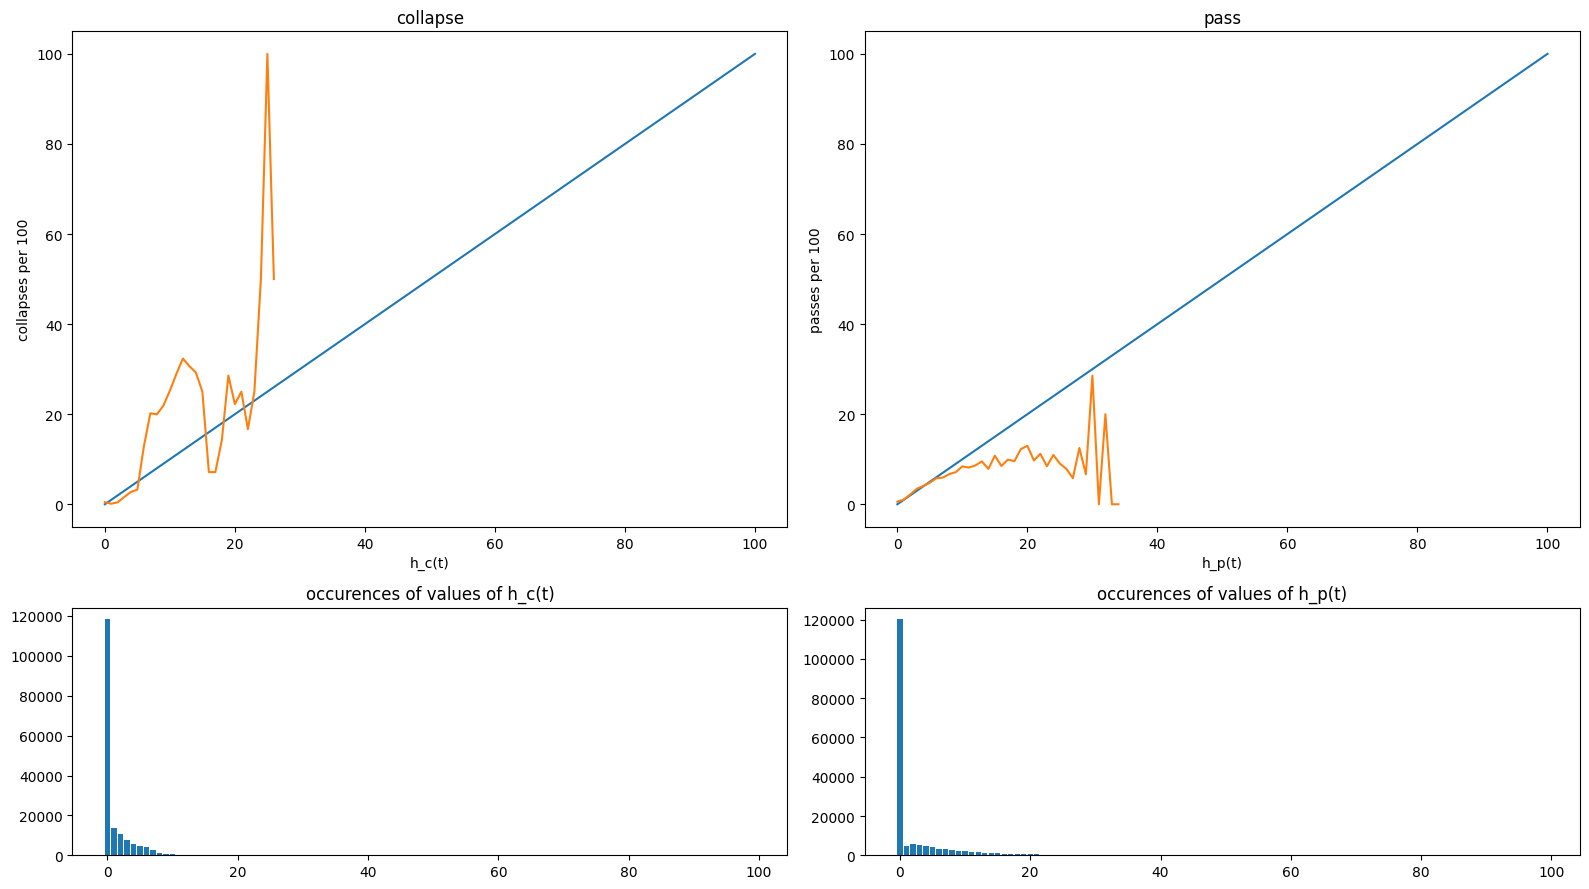

In [255]:
fig, ax = plt.subplots(2,2, figsize=(16,9), height_ratios=(2,1))
ax[0,0].plot([0,100], [0,100])
ax[0,0].plot([np.mean(bucket)*100 for bucket in collapse_calib])
ax[0,0].set_title("collapse")
ax[0,0].set_xlabel("h_c(t)")
ax[0,0].set_ylabel("collapses per 100")
ax[0,1].plot([0,100], [0,100])
ax[0,1].plot([np.mean(bucket)*100 for bucket in pass_calib])
ax[0,1].set_xlabel("h_p(t)")
ax[0,1].set_ylabel("passes per 100")
ax[0,1].set_title("pass")
ax[1,0].bar(np.arange(100), [len(bucket) for bucket in collapse_calib])
ax[1,0].set_title("occurences of values of h_c(t)")
ax[1,1].bar(np.arange(100), [len(bucket) for bucket in pass_calib])
ax[1,1].set_title("occurences of values of h_p(t)")
fig.tight_layout()
plt.show()


<Axes: >

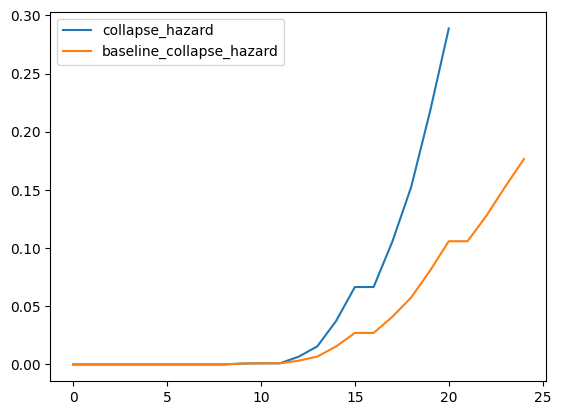

In [140]:
df[["collapse_hazard", "baseline_collapse_hazard"]].cumsum().head(25).plot()

In [107]:
# we have df in 5er buckets. we have collapse event bool, we have event timing. so> how large was hazard before shit hit the fan? 